<a href="https://colab.research.google.com/github/rtedwards/nn-zero-to-hero/blob/main/2_makemore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MultiLayer Perceptron (MLP) character-level language model using Bag of Words

Based on [A Neural Probabilistic Language Model (Bengio et al)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- they use a word-level model
- we will use a character-level model



In [164]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

In [2]:
words = open("names.txt", "r").read().splitlines()

## O. Build vocabulary mappings

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### I. Build the dataset

In [267]:
def build_dataset(words, bloack_size = 3):
    """
    - block_size - context length: how many characters fo we take to predict the next one?
    """
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y

## II. Data set Splits

- Training (80%) - used to optimize the model parameters
- Validation (10%) - used to optimize the model hyperparameters(number of neurons, size of hidden layer, size of embedding, strength of regularization)
- Test (10%) - used to evaluate model as it generalizes to unseen data

In [268]:
# train / validation / test splits
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
block_size = 5

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182437, 5]) torch.Size([182437])
torch.Size([22781, 5]) torch.Size([22781])
torch.Size([22928, 5]) torch.Size([22928])


## III. Initialize Network

In [269]:
n_dims = 10 # number of dimensions in embeddings
n_inputs = block_size * n_dims
g = torch.Generator().manual_seed(2147483647) # for reproducability
C = torch.randn((27, n_dims), generator=g)      # 3 embeddings
W1 = torch.randn((n_inputs, 200), generator=g)    # 3 x 10 inputs
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [270]:
sum(p.nelement() for p in parameters) # number of parameters in total

15897

## IV. Training

In [271]:
n_iters = 200_000

# exponentially stepped Learning Rates
lre = torch.linspace(-3, 0, n_iters)
lrs = 10**lre

lr_i = []
loss_i = []
step_i = []

In [272]:
for i in tqdm(range(n_iters)):
    # minibatch construct of 32 examples
    ix = torch.randint(0, X_train.shape[0], (32,))

    # Forward Pass
    emb = C[X_train[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, n_inputs) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2                      # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y_train[ix]) # equal to above 3 lines

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    # lr = lrs[i]
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track Stats
    step_i.append(i)
    lr_i.append(lre[i])
    loss_i.append(loss.log10().item())

print(f"minibatch loss: {loss.item()}")

  0%|          | 0/200000 [00:00<?, ?it/s]

minibatch loss: 1.9106916189193726


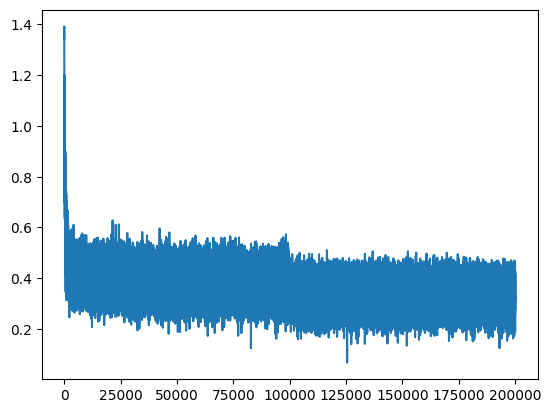

In [273]:
plt.plot(step_i, loss_i)
# good learning rates in the minimum (-1.0 to -0.5)

In [274]:
# Training Loss
emb = C[X_train] # (32, 3, 2)
h = torch.tanh(emb.view(-1, n_inputs) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train) # equal to above 3 lines
print(f"Training loss: {loss.item()}")

Training loss: 2.2027506828308105


In [275]:
# Validation Loss
emb = C[X_val] # (32, 3, 2)
h = torch.tanh(emb.view(-1, n_inputs) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val) # equal to above 3 lines
print(f"Validation loss: {loss.item()}")

Validation loss: 2.230646848678589


### Visualize Embeddings (2D)
This only makes sense if the embedding dimension is 2

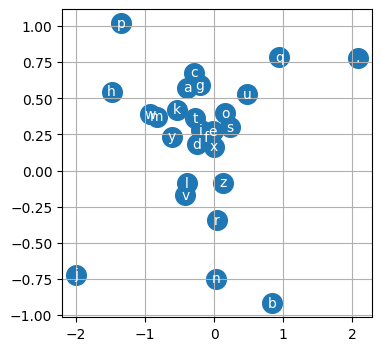

In [265]:
plt.figure(figsize=(4,4))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")

plt.grid("minor")

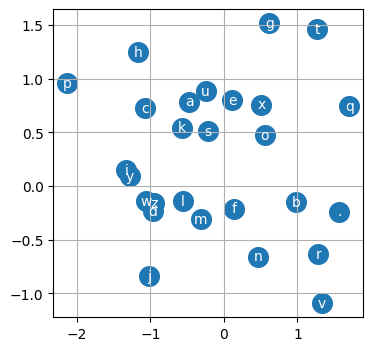

In [252]:
plt.figure(figsize=(4,4))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")

plt.grid("minor")

## Inference

In [276]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, bloack_size)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print("".join(itos[i] for i in out))

junide.
janalia.
prelay.
adina.
jiirleigh.
amaret.
kalania.
zamileeha.
kabya.
newie.
lessi.
jean.
arrellarium.
kafon.
majan.
nasliah.
jani.
coreay.
ebon.
jaevani.


# Notes

## I. Underfitting
The model is underfitting because the training loss and validation loss are close.  This means our network is small and can scale it up by changing our hyperparameters:
- neruons in hidden layer (tanh)
- change dimensionality in embedding layer of the characters
- change number of characters in input layer
- learning rate
- number of iterations
- minibatch size

## II. Embedding Concatenation
We need to concate the embeddings for the 2 words (chars) together to be able to matrix multiply with `W1`.

1. `torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)`
2. `torch.cat(torch.unbind(emb, 1))`
3. `emb.view(32, 6)`

In [50]:
# need to concate the embeddings for the 3 words (characters)
emb_cat = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)
emb_unbind = torch.cat(torch.unbind(emb, 1), 1)
emb_view = emb.view(32, 6)

emb_cat.shape, emb_unbind.shape, emb_view.shape

(torch.Size([32, 6]), torch.Size([32, 6]), torch.Size([32, 6]))